<a href="https://colab.research.google.com/github/aww-semenyuk/toxic-comments-classification/blob/aww-semenyuk/ml_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text preprocessing

In [ ]:
from google.colab import userdata
import os

os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

 98% 707M/723M [00:03<00:00, 232MB/s]
100% 723M/723M [00:03<00:00, 197MB/s]


In [ ]:
!unzip "jigsaw-unintended-bias-in-toxicity-classification.zip" -d "/content/data"

Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: /content/data/all_data.csv  
  inflating: /content/data/identity_individual_annotations.csv  
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/test_private_expanded.csv  
  inflating: /content/data/test_public_expanded.csv  
  inflating: /content/data/toxicity_individual_annotations.csv  
  inflating: /content/data/train.csv  


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/data/train.csv', parse_dates=['created_date'], date_format='ISO8601').rename(columns={'target': 'toxicity'})
df.head()

,id,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
import re
import unicodedata
import string

from tqdm.notebook import tqdm

import spacy

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
class PreprocLemmaTokenizer:
    nlp = spacy.load('en_core_web_sm')
    stopwords = set(nltk.corpus.stopwords.words('english'))
    url_extract_domain_pattern = re.compile(r'^(?:https?://)?(?:www\.)?([^/]+?)(/.+)?$')

    def __init__(self):
        pass

    @staticmethod
    def normalize_text(doc):
        return unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    @classmethod
    def lemma_or_url_domain(cls, spacy_token):
        return cls.url_extract_domain_pattern.sub(r'\1', spacy_token.text) if spacy_token.like_url else spacy_token.lemma_

    def process_docs(self, corpus, batch_size=64):
        results = []

        corpus_normalized = [self.normalize_text(doc) for doc in corpus]
        pipe = self.nlp.pipe(corpus_normalized, disable=['ner', 'parser'], batch_size=batch_size)

        for doc in tqdm(pipe, total=len(corpus)):
            results.append([self.lemma_or_url_domain(token).lower() for token in doc if not (token.lemma_.lower() in self.stopwords or token.is_space or token.is_punct)])

        return results

In [ ]:
tknzr = PreprocLemmaTokenizer()

tokenized_lst = tknzr.process_docs(df['comment_text'].astype('str'))

  0%|          | 0/1804874 [00:00<?, ?it/s]

In [ ]:
df['comment_text_tokenized_tab'] = pd.Series(tokenized_lst).apply('\t'.join).values

In [ ]:
df[['comment_text', 'comment_text_tokenized_tab']].head()

,comment_text,comment_text_tokenized_tab
0,"This is so cool. It's like, 'would you want yo...",cool\tlike\twould\twant\tmother\tread\treally\...
1,Thank you!! This would make my life a lot less...,thank\twould\tmake\tlife\tlot\tless\tanxiety\t...
2,This is such an urgent design problem; kudos t...,urgent\tdesign\tproblem\tkudo\ttake\timpressive
3,Is this something I'll be able to install on m...,something\table\tinstall\tsite\trelease
4,haha you guys are a bunch of losers.,haha\tguy\tbunch\tloser


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/toxic_comments_tmp/

mkdir: cannot create directory ‘/content/drive/MyDrive/toxic_comments_tmp/’: File exists


In [ ]:
df.to_csv('/content/drive/MyDrive/toxic_comments_tmp/data_tokenized.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/toxic_comments_tmp/data_tokenized.csv', nrows=5)

,id,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,comment_text_tokenized_tab
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool\tlike\twould\twant\tmother\tread\treally\...
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank\twould\tmake\tlife\tlot\tless\tanxiety\t...
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent\tdesign\tproblem\tkudo\ttake\timpressive
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,something\table\tinstall\tsite\trelease
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha\tguy\tbunch\tloser


In [ ]:
drive.flush_and_unmount()

# ML

## Load, clean, split data

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/toxic_comments_tmp/data_tokenized.csv', parse_dates=['created_date'], date_format='ISO8601')

drive.flush_and_unmount()

df.head()

Mounted at /content/drive


,id,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,comment_text_tokenized_tab
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool\tlike\twould\twant\tmother\tread\treally\...
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank\twould\tmake\tlife\tlot\tless\tanxiety\t...
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent\tdesign\tproblem\tkudo\ttake\timpressive
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,something\table\tinstall\tsite\trelease
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha\tguy\tbunch\tloser


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [4]:
toxicity_cols = [
    'toxicity',
    'obscene',
    'identity_attack',
    'insult',
    'threat',
    'sexual_explicit']

for col in toxicity_cols:
    df[col] = np.where(df[col] >= 0.4, 1, 0)

df = df.astype({x:'int8' for x in toxicity_cols})

In [5]:
df = df.dropna(subset='comment_text').sort_values(by='toxicity_annotator_count', ascending=False).drop_duplicates(subset='comment_text', keep='first').reset_index(drop=True)
df['comment_text_tokenized_tab'] = df['comment_text_tokenized_tab'].fillna('')
df.shape

(1780822, 46)

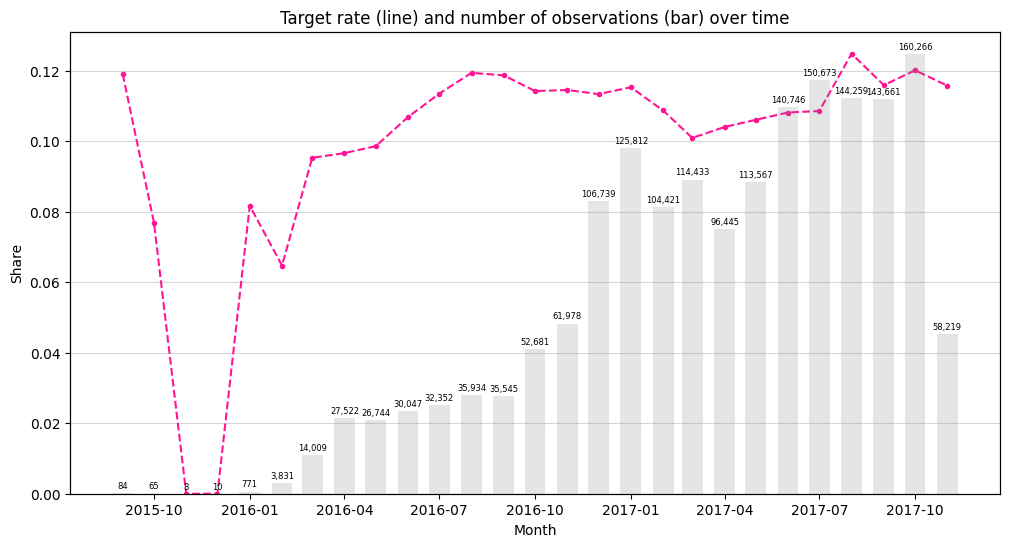

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot('month', 'toxicity', '.--',
        data=df.assign(month=lambda df: df['created_date'].dt.tz_localize(None).to_numpy().astype('datetime64[M]')).groupby('month', as_index=False)['toxicity'].mean(),
        color='deeppink')

ax.set_title('Target rate (line) and number of observations (bar) over time')
ax.set_xlabel('Month')
ax.set_ylabel('Share')
ax.grid(axis='y', alpha=0.5)
ax.set_ylim(bottom=0)

ax1 = ax.twinx()

bar_container = ax1.bar('month', 'comment_text',
                        data=df.assign(month=lambda df: df['created_date'].dt.tz_localize(None).to_numpy().astype('datetime64[M]')).groupby('month', as_index=False)['comment_text'].count(),
                        width=datetime.timedelta(days=20), color='gray', alpha=0.2)

ax1.bar_label(bar_container, fmt='{:,.0f}', padding=2, fontsize=6)

ax1.yaxis.set_visible(False)

plt.show()

In [7]:
df = df[df['created_date'] >= '2016-06-01'].reset_index(drop=True)
df.shape

(1707778, 46)

In [8]:
pd.concat([df[col].value_counts().rename(col) for col in toxicity_cols], axis=1).round(3)

,toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,1515429,1694692,1683539,1563451,1700504,1700176
1,192349,13086,24239,144327,7274,7602


In [9]:
pd.concat([df[col].value_counts(normalize=True).rename(col) for col in toxicity_cols], axis=1).round(3)

,toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.887,0.992,0.986,0.915,0.996,0.996
1,0.113,0.008,0.014,0.085,0.004,0.004


In [10]:

test_split_date = df['created_date'].quantile(0.8)
test_split_mask = (df['created_date'] >= test_split_date)

validation_split_date = df[~test_split_mask]['created_date'].quantile(0.8)
validation_split_mask = (df[~test_split_mask]['created_date'] >= validation_split_date)

text_col = 'comment_text_tokenized_tab'

X, y = df[text_col], df[toxicity_cols]

X_train, y_train, X_test, y_test = (df[text_col][~test_split_mask],
                                    df[toxicity_cols][~test_split_mask],
                                    df[text_col][test_split_mask],
                                    df[toxicity_cols][test_split_mask])

X_train, y_train, X_val, y_val = (X_train[~validation_split_mask],
                                  y_train[~validation_split_mask],
                                  X_train[validation_split_mask],
                                  y_train[validation_split_mask])

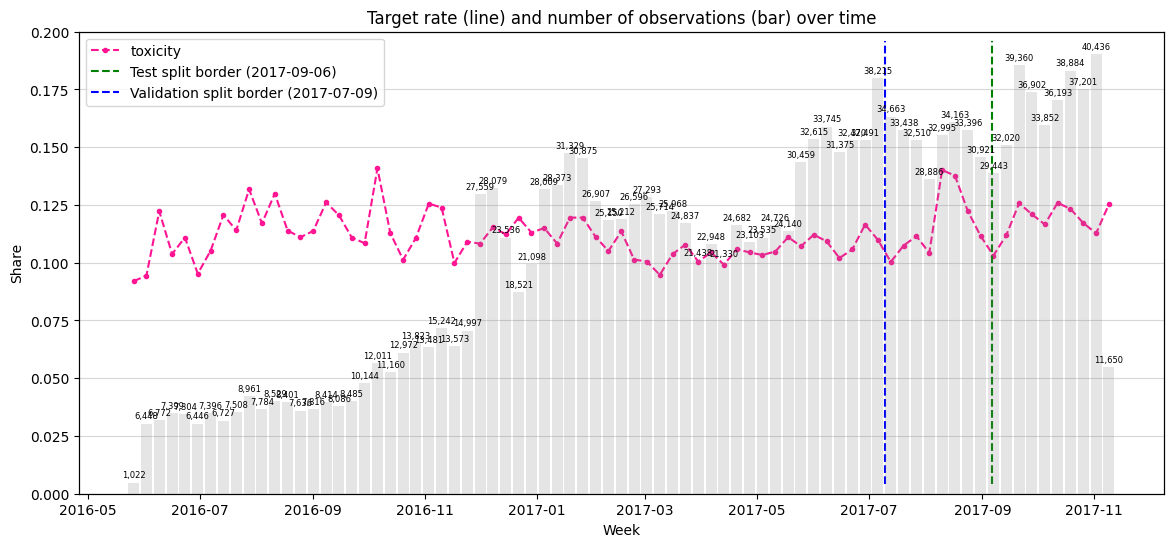

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot('week', 'toxicity', '.--',
        data=df.assign(week=lambda df: df['created_date'].dt.tz_localize(None).to_numpy().astype('datetime64[W]')).groupby('week', as_index=False)['toxicity'].mean(),
        color='deeppink')

ax.set_title('Target rate (line) and number of observations (bar) over time')
ax.set_xlabel('Week')
ax.set_ylabel('Share')
ax.grid(axis='y', alpha=0.5)
ax.set_ylim(bottom=0, top=0.2)

ax.vlines(test_split_date, ymin=ax.get_ylim()[1]*0.02, ymax=ax.get_ylim()[1]*0.98, ls='--', color='green', lw=1.5, label=f'Test split border ({test_split_date.date()})')
ax.vlines(validation_split_date, ymin=ax.get_ylim()[1]*0.02, ymax=ax.get_ylim()[1]*0.98, ls='--', color='blue', lw=1.5, label=f'Validation split border ({validation_split_date.date()})')

ax.legend(loc='upper left')

ax1 = ax.twinx()

bar_container = ax1.bar('week', 'comment_text',
                        data=df.assign(week=lambda df: df['created_date'].dt.tz_localize(None).to_numpy().astype('datetime64[W]')).groupby('week', as_index=False)['comment_text'].count(),
                        width=datetime.timedelta(days=6), color='gray', alpha=0.2)

ax1.bar_label(bar_container, fmt='{:,.0f}', padding=2, fontsize=6)

ax1.yaxis.set_visible(False)

plt.show()

In [12]:
for y, name in zip([y_train, y_val, y_test], ['Train', 'Validation', 'Test']):
    print(f'{name} set, len={len(y):,.0f}')
    print(pd.concat([y[col].value_counts().rename(col) for col in toxicity_cols], axis=1).round(3), '\n')

Train set, len=1,092,977
   toxicity  obscene  identity_attack   insult   threat  sexual_explicit
0    972735  1084605          1078623  1002370  1088377          1088290
1    120242     8372            14354    90607     4600             4687 

Validation set, len=273,245
   toxicity  obscene  identity_attack  insult  threat  sexual_explicit
0    241468   271280           268856  249519  272070           272171
1     31777     1965             4389   23726    1175             1074 

Test set, len=341,556
   toxicity  obscene  identity_attack  insult  threat  sexual_explicit
0    301226   338807           336060  311562  340057           339715
1     40330     2749             5496   29994    1499             1841 



In [13]:
for y, name in zip([y_train, y_val, y_test], ['Train', 'Validation', 'Test']):
    print(f'{name} set, len={len(y):,.0f}')
    print(pd.concat([y[col].value_counts(normalize=True).rename(col) for col in toxicity_cols], axis=1).round(3), '\n')

Train set, len=1,092,977
   toxicity  obscene  identity_attack  insult  threat  sexual_explicit
0      0.89    0.992            0.987   0.917   0.996            0.996
1      0.11    0.008            0.013   0.083   0.004            0.004 

Validation set, len=273,245
   toxicity  obscene  identity_attack  insult  threat  sexual_explicit
0     0.884    0.993            0.984   0.913   0.996            0.996
1     0.116    0.007            0.016   0.087   0.004            0.004 

Test set, len=341,556
   toxicity  obscene  identity_attack  insult  threat  sexual_explicit
0     0.882    0.992            0.984   0.912   0.996            0.995
1     0.118    0.008            0.016   0.088   0.004            0.005 



## Dummy baseline

In [14]:
!pip install -q optuna

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score, classification_report, average_precision_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import optuna

from functools import partial

### Dummy Single label

In [16]:
%%time
clf_dummy = DummyClassifier(strategy='stratified', random_state=42)
clf_dummy.fit(X_train, y_train['toxicity'])

CPU times: user 43.4 ms, sys: 777 µs, total: 44.2 ms
Wall time: 52.5 ms


DummyClassifier(random_state=42, strategy='stratified')

In [17]:
def plot_metrics_single(estimator, model_name, label_name, X_left, y_left, X_right, y_right, left_set_name, right_set_name):
    '''
    estimator
        fitted instance of a model
    model_name: str
        info about model to show in title
    label_name: str
        predicted label name
    '''
    y_left_pred = estimator.predict(X_left)
    y_left_pred_proba = estimator.predict_proba(X_left)
    y_right_pred = estimator.predict(X_right)
    y_right_pred_proba = estimator.predict_proba(X_right)

    y_pred_dict = {
        left_set_name: y_left_pred,
        f'{left_set_name}_proba': y_left_pred_proba,
        right_set_name: y_right_pred,
        f'{right_set_name}_proba': y_right_pred_proba
    }

    y_true_dict = {
        left_set_name: y_left,
        right_set_name: y_right
    }

    def plot_metrics_table(y_true, y_pred, set_name, ax):
        tbl = pd.DataFrame.from_dict({'precision': precision_score(y_true, y_pred, zero_division=np.nan),
                                      'recall': recall_score(y_true, y_pred, zero_division=np.nan),
                                      'f1-score': f1_score(y_true, y_pred, zero_division=np.nan)}, orient='index').T
        ax.table(cellText=tbl.values.round(2), colLabels=tbl.columns.values, loc='center')
        ax.axis('off')
        ax.set_title(f'{set_name}', loc='left')

    def plot_confusion_matrix(y_true, y_pred, ax):
        sns.heatmap(confusion_matrix(y_true, y_pred, normalize='all'), annot=True, ax=ax, fmt='.1%', cmap='Blues')
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_title('Confusion Matrix', loc='left', fontsize='small')

    def plot_roc_curve(y_true, y_pred_proba, ax):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'ROC curve: AUC={auc(fpr, tpr):.2f}', loc='left', fontsize='small')
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)
        ax.grid()

    def plot_pr_curve(y_true, y_pred_proba, ax):
        prec, rec, _ = precision_recall_curve(y_true, y_pred_proba)
        sorted_index = np.argsort(rec)
        prec = prec[sorted_index]
        rec = rec[sorted_index]
        ax.plot(rec, prec)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall curve: AUC={auc(rec, prec):.2f}', loc='left', fontsize='small')
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)
        ax.grid()

    fig = plt.figure(figsize=(8, 8), layout='constrained')
    gs = fig.add_gridspec(4, 2, height_ratios=[0.05, 0.15, 0.35, 0.35])
    nrows, ncols = gs.get_geometry()
    ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

    for colnum, set_name in enumerate([left_set_name, right_set_name]):
        plot_metrics_table(y_true_dict[set_name], y_pred_dict[set_name], set_name, ax[0][colnum])
        plot_confusion_matrix(y_true_dict[set_name], y_pred_dict[set_name], ax[1][colnum])
        plot_roc_curve(y_true_dict[set_name], y_pred_dict[f'{set_name}_proba'][:, 1], ax[2][colnum])
        plot_pr_curve(y_true_dict[set_name], y_pred_dict[f'{set_name}_proba'][:, 1], ax[3][colnum])

    fig.suptitle(f'Classification metrics for {model_name}, "{label_name}" label')

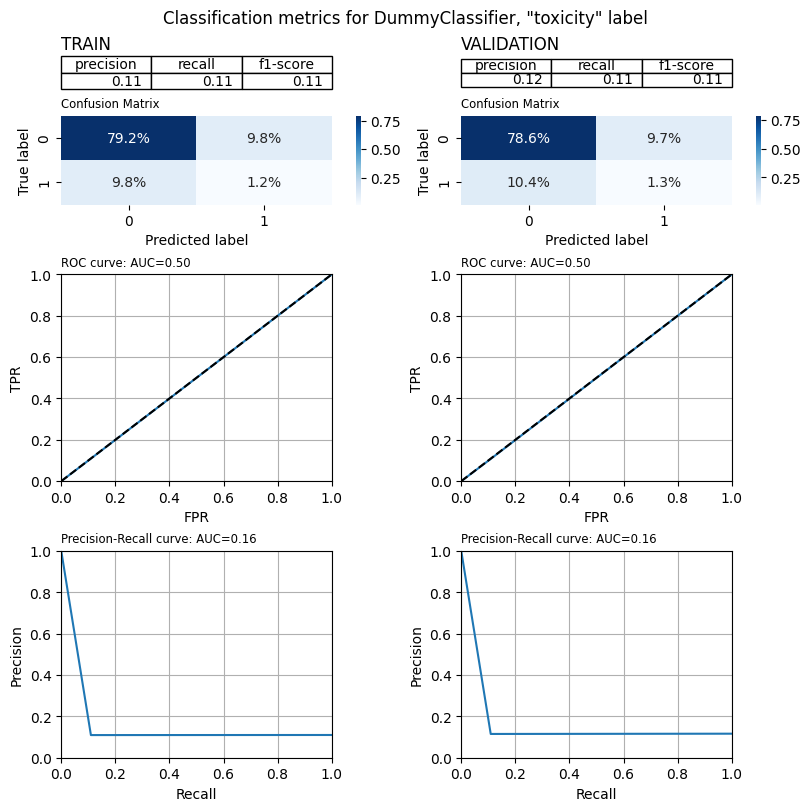

In [18]:
plot_metrics_single(clf_dummy, 'DummyClassifier', 'toxicity', X_train, y_train['toxicity'], X_val, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### Dummy Multilabel

In [19]:
%%time
clf_dummy_mo = MultiOutputClassifier(DummyClassifier(strategy='stratified', random_state=42))
clf_dummy_mo.fit(X_train, y_train)

CPU times: user 392 ms, sys: 2.93 ms, total: 395 ms
Wall time: 422 ms


MultiOutputClassifier(estimator=DummyClassifier(random_state=42,
                                                strategy='stratified'))

In [20]:
def plot_metrics_multi(estimator, model_name, label_names, X_left, y_left, X_right, y_right, left_set_name, right_set_name):
    '''
    estimator
        fitted on (X_train, y_train) instance of a model
    model_name: str
        info about model to show in title
    label_names: str
        class labels
    '''
    y_left_pred = estimator.predict(X_left)
    y_left_pred_proba = np.array([arr[:, 1] for arr in estimator.predict_proba(X_left)]).T
    y_right_pred = estimator.predict(X_right)
    y_right_pred_proba = np.array([arr[:, 1] for arr in estimator.predict_proba(X_right)]).T

    y_pred_dict = {
        left_set_name: y_left_pred,
        f'{left_set_name}_proba': y_left_pred_proba,
        right_set_name: y_right_pred,
        f'{right_set_name}_proba': y_right_pred_proba
    }

    y_true_dict = {
        left_set_name: y_left,
        right_set_name: y_right
    }

    def plot_metrics_table(y_true, y_pred, set_name, ax):
        tbl = pd.DataFrame.from_dict(classification_report(y_true, y_pred, zero_division=np.nan, target_names=label_names, output_dict=True)) \
            .drop(['weighted avg', 'samples avg'], axis=1) \
            .T \
            .astype('float64') \
            .apply(lambda s: s.apply('{:,.0f}'.format) if s.name=='support' else s.apply('{:.2f}'.format), axis=0)
        ax_tbl = ax.table(cellText=tbl.values, rowLabels=tbl.index.values, colLabels=tbl.columns.values, loc='center')
        ax_tbl.auto_set_font_size(False)
        ax_tbl.set_fontsize('small')
        ax.axis('off')
        ax_tbl.scale(1, 0.7)
        ax.set_title(f'{set_name}', loc='left')

    def plot_roc_curve(y_true, y_pred_proba, ax):
        for i, label in enumerate(label_names):
            fpr, tpr, _ = roc_curve(y_true[:,i], y_pred_proba[:,i])
            ax.plot(fpr, tpr, label=f'ROC for {label}, AUC={auc(fpr, tpr):.2f}')

        fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
        ax.plot(fpr_micro, tpr_micro, '--', label=f'micro-average ROC curve, AUC={auc(fpr_micro, tpr_micro):.2f}')

        ax.plot([0, 1], [0, 1], 'k--', lw=0.5, label='Chance level, AUC=0.5')

        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(fontsize='x-small', loc='lower right')
        ax.set_title(f'ROC', loc='left', fontsize='small')
        ax.grid()
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)

    def plot_pr_curve(y_true, y_pred_proba, ax):
        for i, label in enumerate(label_names):
            prec, rec, _ = precision_recall_curve(y_true[:,i], y_pred_proba[:,i])
            sorted_index = np.argsort(rec)
            prec = prec[sorted_index]
            rec = rec[sorted_index]
            ax.plot(rec, prec, label=f'P-R for {label}, AUC={auc(rec, prec):.2f}, AP={average_precision_score(y_true[:,i], y_pred_proba[:,i]):.2f}')

        prec_micro, rec_micro, _ = precision_recall_curve(y_true.ravel(), y_pred_proba.ravel())
        sorted_index = np.argsort(rec_micro)
        prec_micro = prec_micro[sorted_index]
        rec_micro = rec_micro[sorted_index]
        ax.plot(rec_micro, prec_micro, '--', label=f'micro-average PR curve, AUC={auc(rec_micro, prec_micro):.2f}, AP={average_precision_score(y_true, y_pred_proba, average="micro"):.2f}')

        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            (l,) = ax.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            ax.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize='x-small')

        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)

        handles, labels = ax.get_legend_handles_labels()
        handles.extend([l])
        labels.extend(['iso f1 curves'])
        ax.legend(handles=handles, labels=labels, loc='best', fontsize='x-small')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall', loc='left', fontsize='small')
        ax.grid()

    fig = plt.figure(figsize=(9, 9), layout='constrained')
    gs = fig.add_gridspec(3, 2, height_ratios=[0.18, 0.41, 0.41])
    nrows, ncols = gs.get_geometry()
    ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

    for colnum, set_name in enumerate([left_set_name, right_set_name]):
        plot_metrics_table(y_true_dict[set_name], y_pred_dict[set_name], set_name, ax[0][colnum])
        plot_roc_curve(y_true_dict[set_name].values, y_pred_dict[f'{set_name}_proba'], ax[1][colnum])
        plot_pr_curve(y_true_dict[set_name].values, y_pred_dict[f'{set_name}_proba'], ax[2][colnum])

    fig.suptitle(f'Multilabel classification metrics for {model_name}')

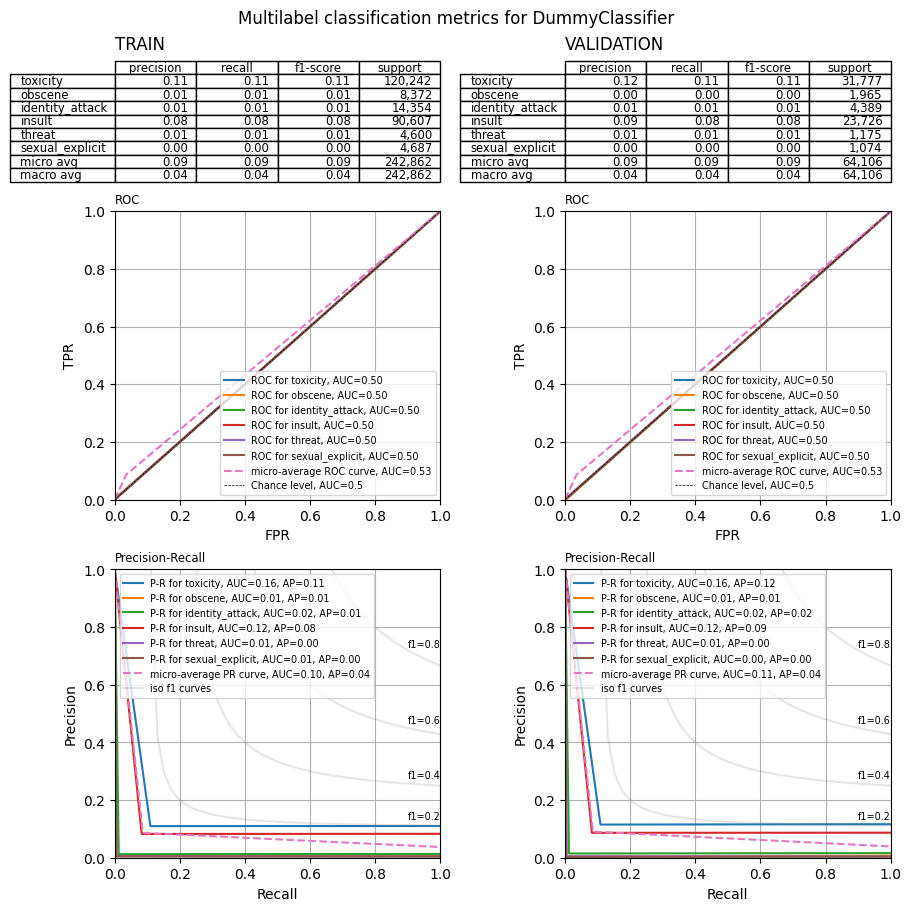

In [21]:
plot_metrics_multi(clf_dummy_mo, 'DummyClassifier', toxicity_cols, X_train, y_train, X_val, y_val, 'TRAIN', 'VALIDATION')

## LogisticRegression

### LogReg default params, default BoW, single label ("toxicity")

In [22]:
%%time
vec = CountVectorizer(ngram_range=(1, 1),
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_bow = vec.fit_transform(X_train)
X_val_bow = vec.transform(X_val)

CPU times: user 23.3 s, sys: 382 ms, total: 23.7 s
Wall time: 30 s


In [23]:
X_train_bow.shape

(1092977, 265972)

In [24]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_bow, y_train['toxicity'])

CPU times: user 1min 31s, sys: 18 s, total: 1min 49s
Wall time: 1min 5s


LogisticRegression(max_iter=1000)

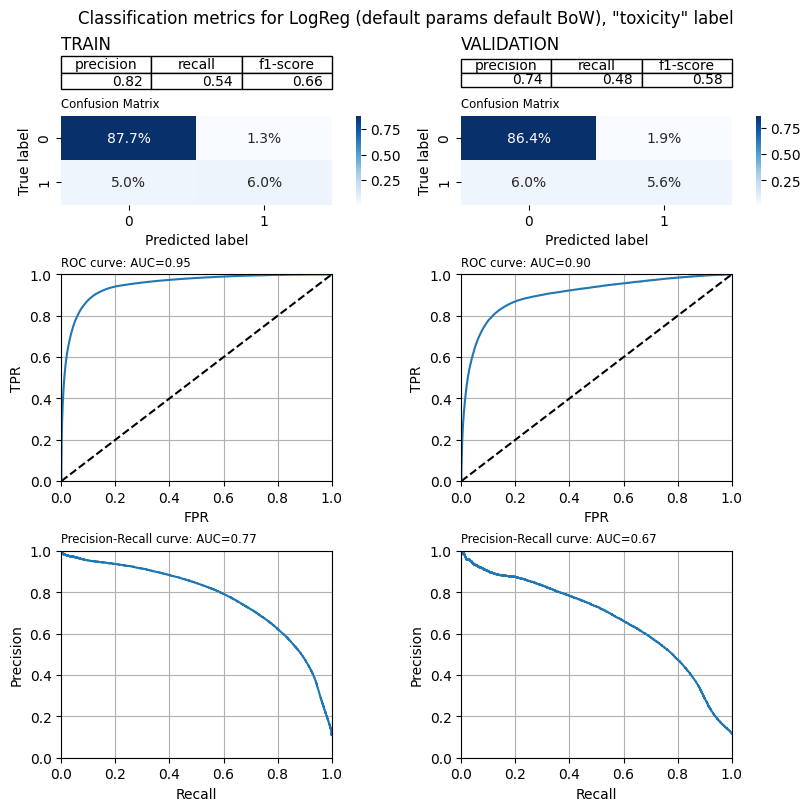

In [25]:
plot_metrics_single(lr, 'LogReg (default params default BoW)', 'toxicity',  X_train_bow, y_train['toxicity'], X_val_bow, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### LogReg default params, default BoW, single label ("threat")

In [26]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_bow, y_train['threat'])

CPU times: user 10.7 s, sys: 2.26 s, total: 12.9 s
Wall time: 7.69 s


LogisticRegression(max_iter=1000)

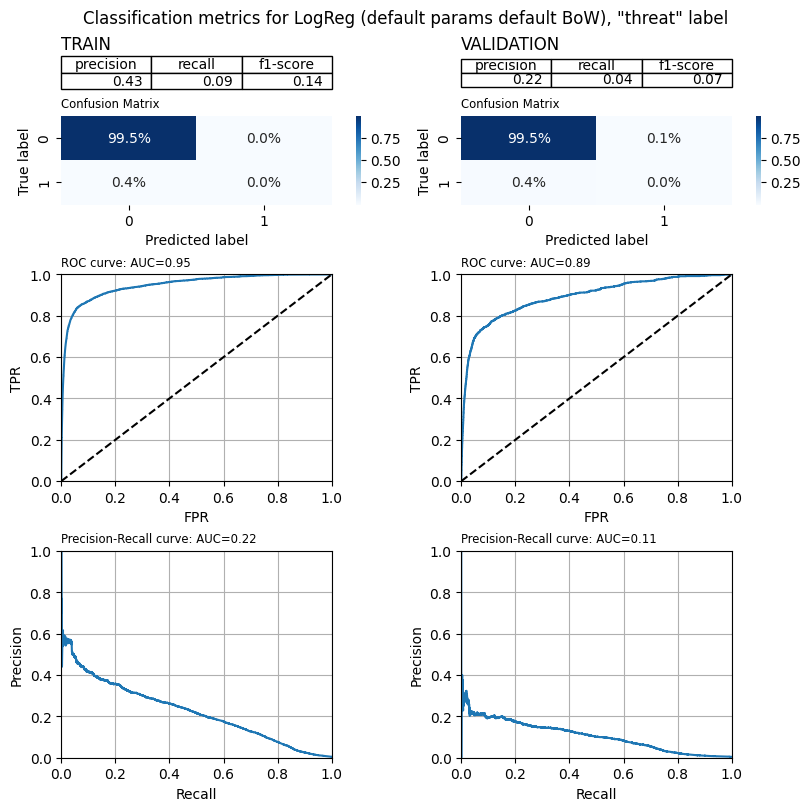

In [27]:
plot_metrics_single(lr, 'LogReg (default params default BoW)', 'threat',  X_train_bow, y_train['threat'], X_val_bow, y_val['threat'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df BoW, single label ("toxicity")

In [28]:
%%time
vec = CountVectorizer(ngram_range=(1, 1),
                      min_df=0.0005,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_bow = vec.fit_transform(X_train)
X_val_bow = vec.transform(X_val)

CPU times: user 18.9 s, sys: 446 ms, total: 19.3 s
Wall time: 19.4 s


In [29]:
X_train_bow.shape

(1092977, 5247)

In [30]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_bow, y_train['toxicity'])

CPU times: user 7.25 s, sys: 42.2 ms, total: 7.29 s
Wall time: 7.34 s


LogisticRegression(max_iter=1000)

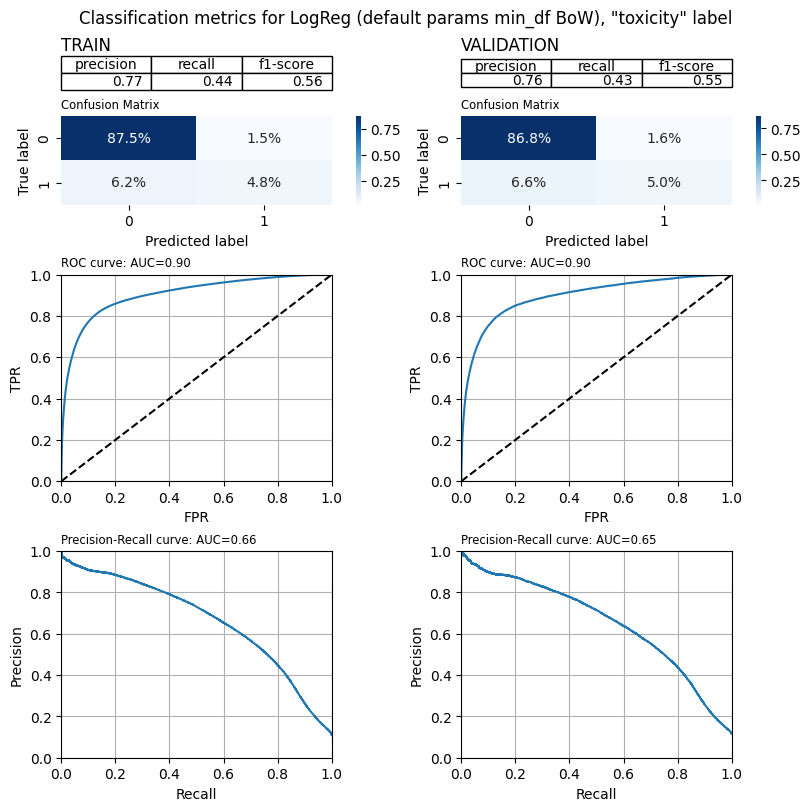

In [31]:
plot_metrics_single(lr, 'LogReg (default params min_df BoW)', 'toxicity',  X_train_bow, y_train['toxicity'], X_val_bow, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df BoW, single label ("threat")

In [32]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_bow, y_train['threat'])

CPU times: user 4.14 s, sys: 46 ms, total: 4.18 s
Wall time: 7.2 s


LogisticRegression(max_iter=1000)

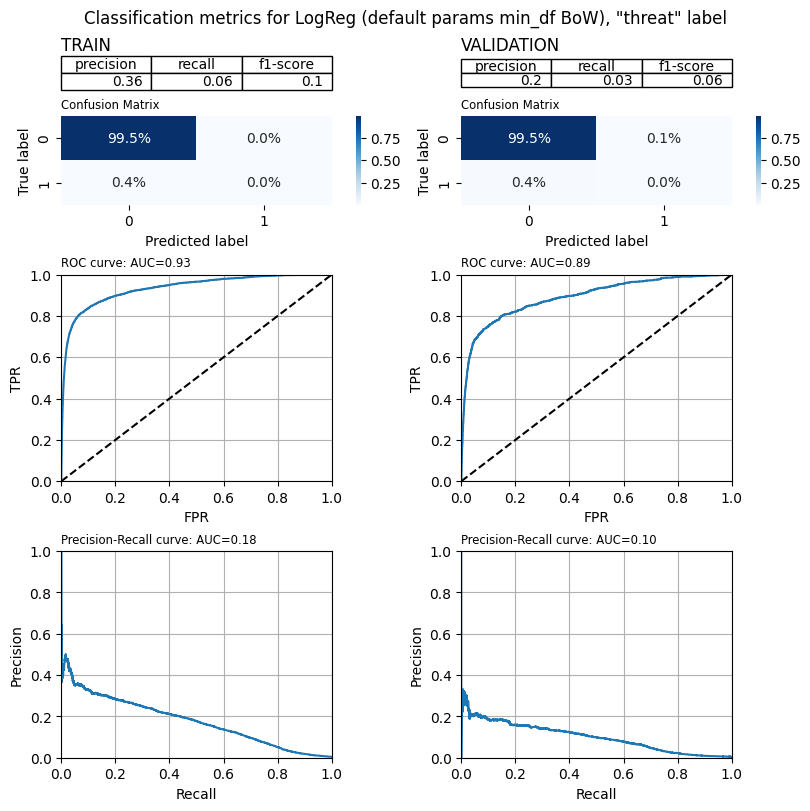

In [33]:
plot_metrics_single(lr, 'LogReg (default params min_df BoW)', 'threat',  X_train_bow, y_train['threat'], X_val_bow, y_val['threat'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df ngram BoW, single label ("toxicity")

In [34]:
%%time
vec = CountVectorizer(ngram_range=(1, 2),
                      min_df=0.0005,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_bow = vec.fit_transform(X_train)
X_val_bow = vec.transform(X_val)

CPU times: user 1min 8s, sys: 2.45 s, total: 1min 10s
Wall time: 1min 11s


In [35]:
X_train_bow.shape

(1092977, 6849)

In [36]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_bow, y_train['toxicity'])

CPU times: user 8.76 s, sys: 67.4 ms, total: 8.82 s
Wall time: 9.03 s


LogisticRegression(max_iter=1000)

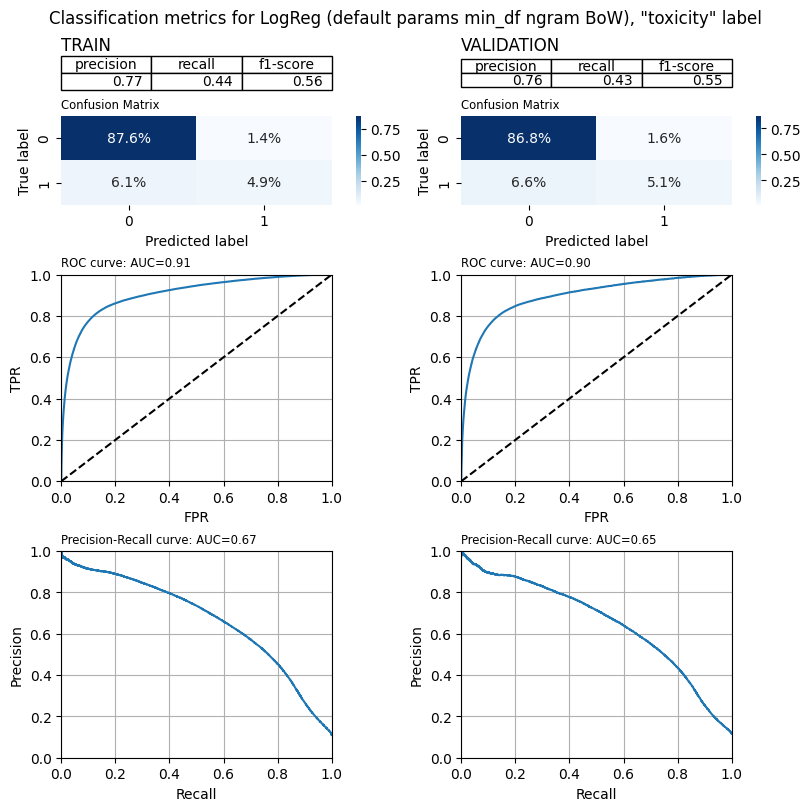

In [37]:
plot_metrics_single(lr, 'LogReg (default params min_df ngram BoW)', 'toxicity',  X_train_bow, y_train['toxicity'], X_val_bow, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df ngram BoW, single label ("threat")

In [38]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_bow, y_train['threat'])

CPU times: user 4.35 s, sys: 60 ms, total: 4.41 s
Wall time: 4.44 s


LogisticRegression(max_iter=1000)

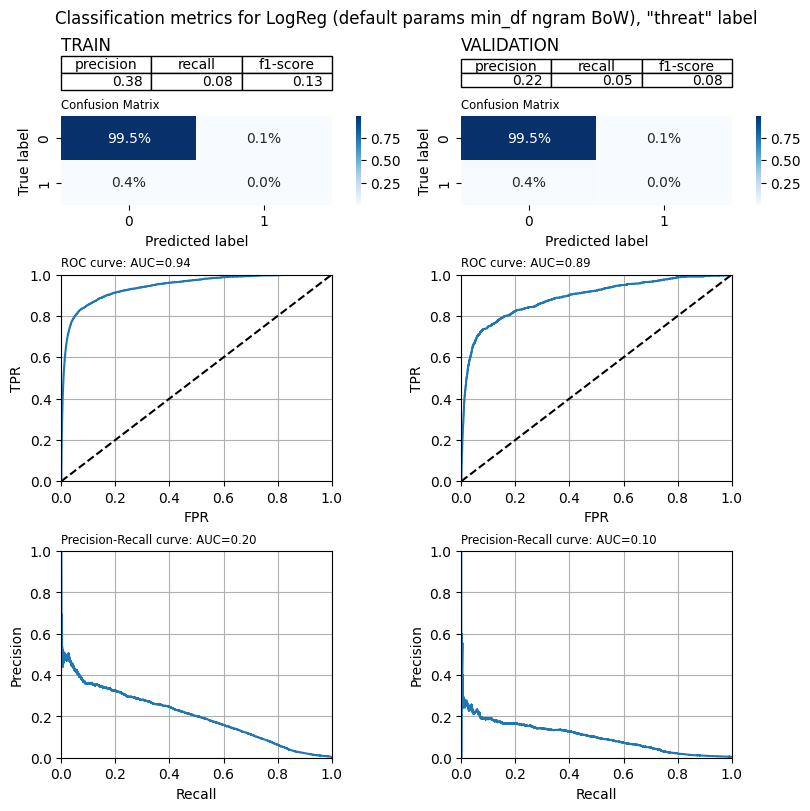

In [39]:
plot_metrics_single(lr, 'LogReg (default params min_df ngram BoW)', 'threat',  X_train_bow, y_train['threat'], X_val_bow, y_val['threat'], 'TRAIN', 'VALIDATION')

### LogReg default params, default TfIdf, single label ("toxicity")

In [40]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_tfidf = vec.fit_transform(X_train)
X_val_tfidf = vec.transform(X_val)

CPU times: user 21.3 s, sys: 578 ms, total: 21.9 s
Wall time: 22 s


In [41]:
X_train_tfidf.shape

(1092977, 265972)

In [42]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_tfidf, y_train['toxicity'])

CPU times: user 23.6 s, sys: 4.99 s, total: 28.6 s
Wall time: 16.3 s


LogisticRegression(max_iter=1000)

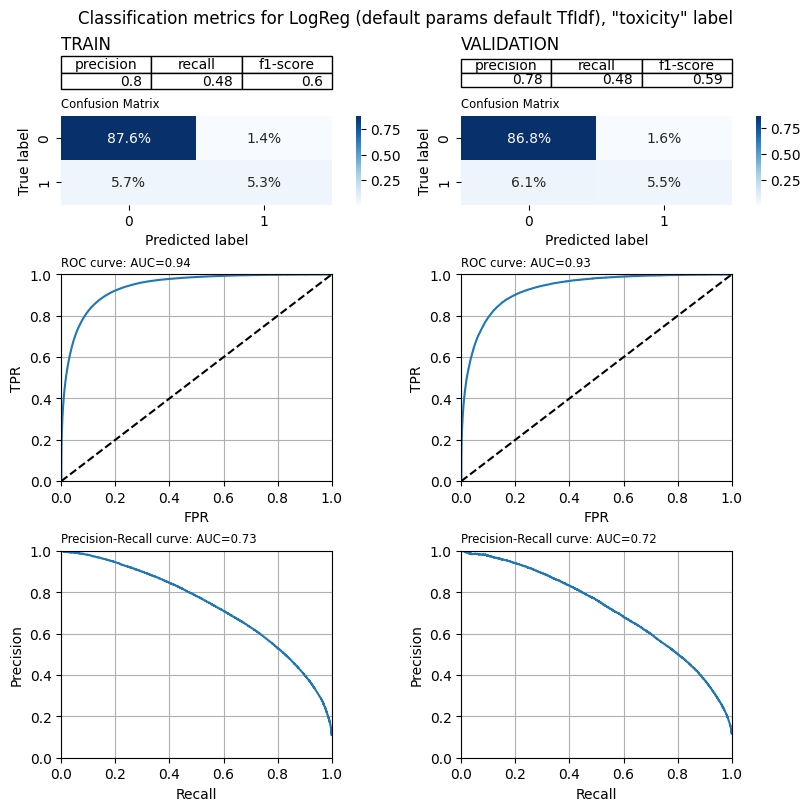

In [43]:
plot_metrics_single(lr, 'LogReg (default params default TfIdf)', 'toxicity',  X_train_tfidf, y_train['toxicity'], X_val_tfidf, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### LogReg default params, default TfIdf, single label ("threat")

In [44]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_tfidf, y_train['threat'])

CPU times: user 8.9 s, sys: 1.76 s, total: 10.7 s
Wall time: 7 s


LogisticRegression(max_iter=1000)

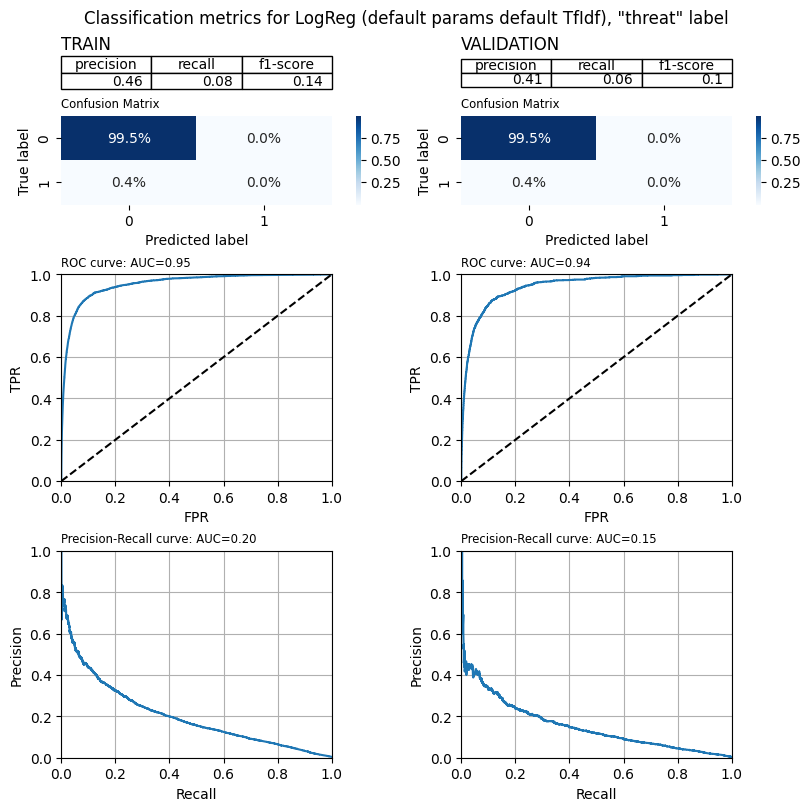

In [45]:
plot_metrics_single(lr, 'LogReg (default params default TfIdf)', 'threat',  X_train_tfidf, y_train['threat'], X_val_tfidf, y_val['threat'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df TfIdf, single label ("toxicity")

In [46]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      min_df=0.0001,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_tfidf = vec.fit_transform(X_train)
X_val_tfidf = vec.transform(X_val)

CPU times: user 20 s, sys: 602 ms, total: 20.6 s
Wall time: 20.7 s


In [47]:
X_train_tfidf.shape

(1092977, 13220)

In [48]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_tfidf, y_train['toxicity'])

CPU times: user 14.1 s, sys: 3.34 s, total: 17.4 s
Wall time: 10.2 s


LogisticRegression(max_iter=1000)

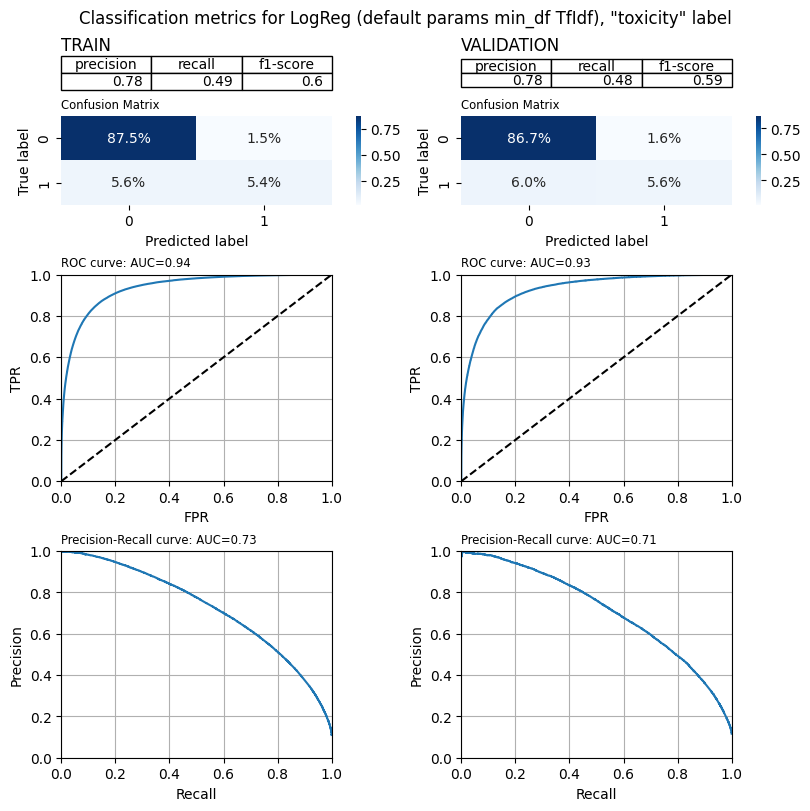

In [49]:
plot_metrics_single(lr, 'LogReg (default params min_df TfIdf)', 'toxicity',  X_train_tfidf, y_train['toxicity'], X_val_tfidf, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df TfIdf, single label ("threat")

In [50]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_tfidf, y_train['threat'])

CPU times: user 8.05 s, sys: 2.1 s, total: 10.2 s
Wall time: 5.36 s


LogisticRegression(max_iter=1000)

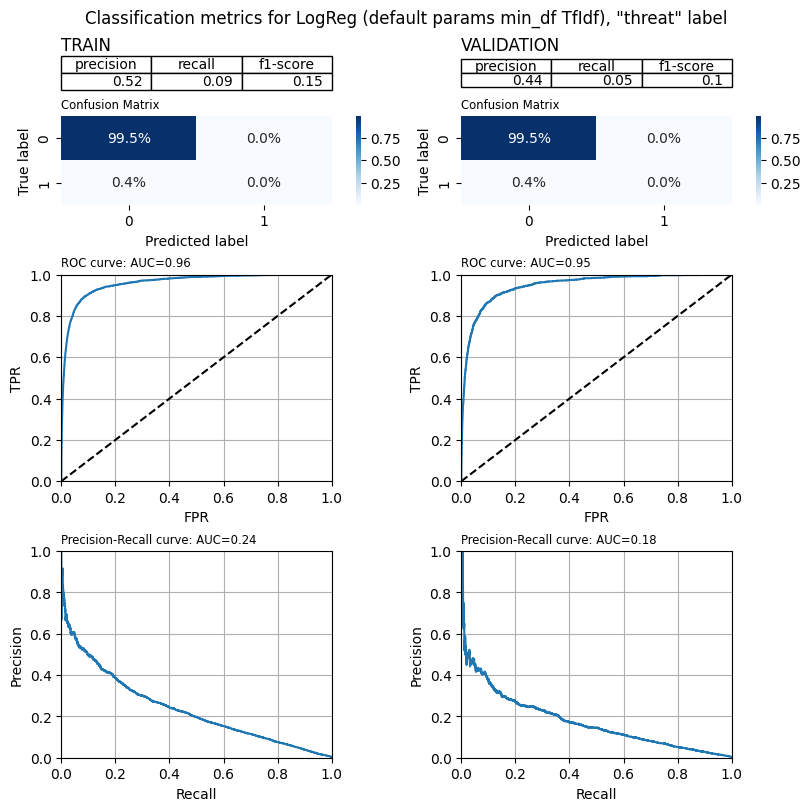

In [51]:
plot_metrics_single(lr, 'LogReg (default params min_df TfIdf)', 'threat',  X_train_tfidf, y_train['threat'], X_val_tfidf, y_val['threat'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df ngram TfIdf, single label ("toxicity")

In [52]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 2),
                      min_df=0.0001,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_tfidf = vec.fit_transform(X_train)
X_val_tfidf = vec.transform(X_val)

CPU times: user 1min 8s, sys: 2.79 s, total: 1min 11s
Wall time: 1min 13s


In [53]:
X_train_tfidf.shape

(1092977, 32019)

In [54]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_tfidf, y_train['toxicity'])

CPU times: user 13.9 s, sys: 2.93 s, total: 16.8 s
Wall time: 10.5 s


LogisticRegression(max_iter=1000)

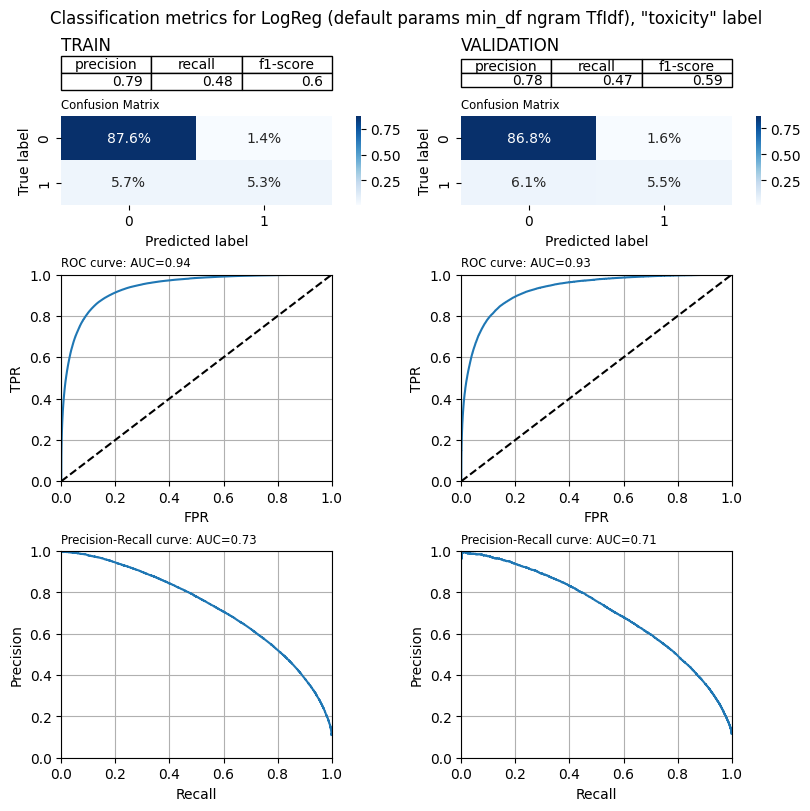

In [55]:
plot_metrics_single(lr, 'LogReg (default params min_df ngram TfIdf)', 'toxicity',  X_train_tfidf, y_train['toxicity'], X_val_tfidf, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### LogReg default params, min_df ngram TfIdf, single label ("threat")

In [56]:
%%time
lr = LogisticRegression(max_iter=10**3)
lr.fit(X_train_tfidf, y_train['threat'])

CPU times: user 6.34 s, sys: 1.57 s, total: 7.91 s
Wall time: 4.13 s


LogisticRegression(max_iter=1000)

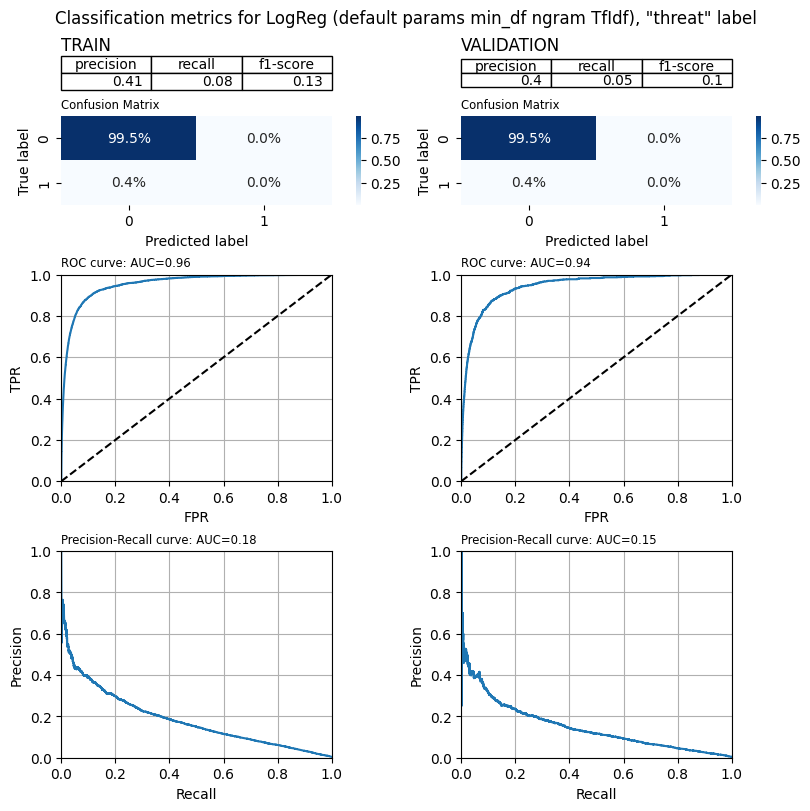

In [57]:
plot_metrics_single(lr, 'LogReg (default params min_df ngram TfIdf)', 'threat',  X_train_tfidf, y_train['threat'], X_val_tfidf, y_val['threat'], 'TRAIN', 'VALIDATION')

### Multilabel LogReg min_df TfIdf (best default) with Optuna

In [58]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      min_df=0.0001,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_tfidf = vec.fit_transform(X_train)
X_val_tfidf = vec.transform(X_val)

CPU times: user 19.7 s, sys: 623 ms, total: 20.3 s
Wall time: 20.4 s


In [59]:
X_train_tfidf.shape

(1092977, 13220)

In [60]:
class ObjectiveLogReg:

    def __init__(self):
        self.best_model = None
        self._model = None

    def __call__(self, trial, X_train, y_train, X_val, y_val):
        params = {
            'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
            'class_weight': 'balanced',
            'max_iter': 10**3,
            'random_state': 42
        }

        model = MultiOutputClassifier(LogisticRegression(**params))
        model.fit(X_train, y_train)

        self._model = model

        return f1_score(y_val, model.predict(X_val), average='micro')

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [61]:
objective_lr_tfidf = ObjectiveLogReg()

study = optuna.create_study(study_name='LogReg TfIdf', direction='maximize')
study.optimize(partial(objective_lr_tfidf, X_train=X_train_tfidf, y_train=y_train, X_val=X_val_tfidf, y_val=y_val),
               n_trials=15,
               callbacks=[objective_lr_tfidf.callback])

[I 2024-12-07 12:21:04,282] A new study created in memory with name: LogReg TfIdf
[I 2024-12-07 12:22:01,680] Trial 0 finished with value: 0.4822045304195086 and parameters: {'C': 0.8589131993020247}. Best is trial 0 with value: 0.4822045304195086.
[I 2024-12-07 12:23:03,749] Trial 1 finished with value: 0.4832979268918028 and parameters: {'C': 0.4947875824554645}. Best is trial 1 with value: 0.4832979268918028.
[I 2024-12-07 12:24:10,287] Trial 2 finished with value: 0.48218692306286215 and parameters: {'C': 1.5201227878394457}. Best is trial 1 with value: 0.4832979268918028.
[I 2024-12-07 12:24:32,300] Trial 3 finished with value: 0.4260372792853439 and parameters: {'C': 0.0020271014279309107}. Best is trial 1 with value: 0.4832979268918028.
[I 2024-12-07 12:25:55,483] Trial 4 finished with value: 0.4823071414143269 and parameters: {'C': 5.118851011294281}. Best is trial 1 with value: 0.4832979268918028.
[I 2024-12-07 12:27:08,202] Trial 5 finished with value: 0.4831079993931844 and 

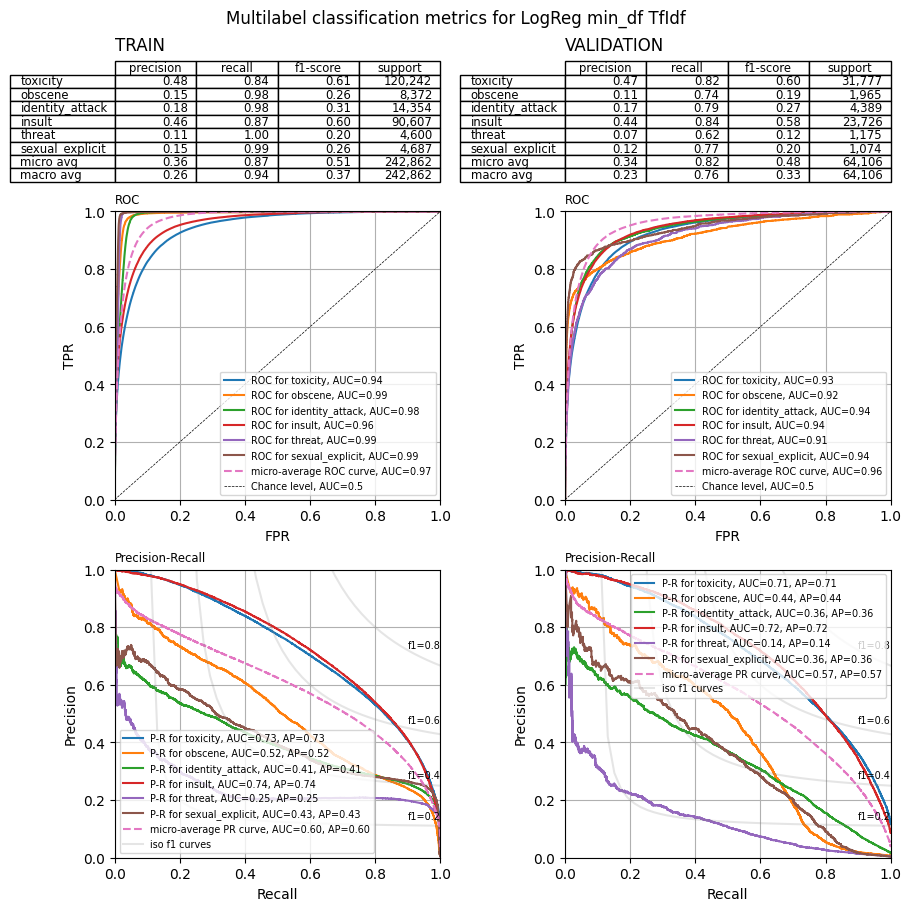

In [62]:
plot_metrics_multi(objective_lr_tfidf.best_model, 'LogReg min_df TfIdf', toxicity_cols, X_train_tfidf, y_train, X_val_tfidf, y_val, 'TRAIN', 'VALIDATION')

In [63]:
import cloudpickle

In [64]:
def save_model_to_drive(model, model_name):
    drive.mount('/content/drive')

    with open(f'/content/drive/MyDrive/toxic_comments_tmp/{model_name}.cloudpickle', 'wb') as f:
        cloudpickle.dump(model, f)

    drive.flush_and_unmount()

In [65]:
save_model_to_drive(objective_lr_tfidf.best_model, 'logreg_tfidf_multilabel')

Mounted at /content/drive


## CatBoost

In [17]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [18]:
from catboost import CatBoostClassifier

### CatBoost TfIdf + SVD, single label ("toxicity")

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      min_df=40,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_tfidf = vec.fit_transform(X_train)
X_val_tfidf = vec.transform(X_val)

CPU times: user 27.5 s, sys: 343 ms, total: 27.8 s
Wall time: 1min 9s


In [21]:
X_train_tfidf.shape

(1092977, 21813)

In [22]:
svd = TruncatedSVD(n_components=300, random_state=42)

In [23]:
%%time
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)

CPU times: user 4min 39s, sys: 33.8 s, total: 5min 13s
Wall time: 4min 21s


In [24]:
X_train_tfidf_reduced.shape

(1092977, 300)

In [25]:
clf_cb = CatBoostClassifier(
    task_type='GPU',
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    subsample=0.6,
    bootstrap_type='Bernoulli',
    border_count=256,
    depth=8,
    iterations=1500,
    learning_rate=0.1,
    l2_leaf_reg=2,
    loss_function='Logloss')

In [ ]:
clf_cb.fit(X_train_tfidf_reduced, y_train['toxicity'], eval_set=(X_val_tfidf_reduced, y_val['toxicity']))

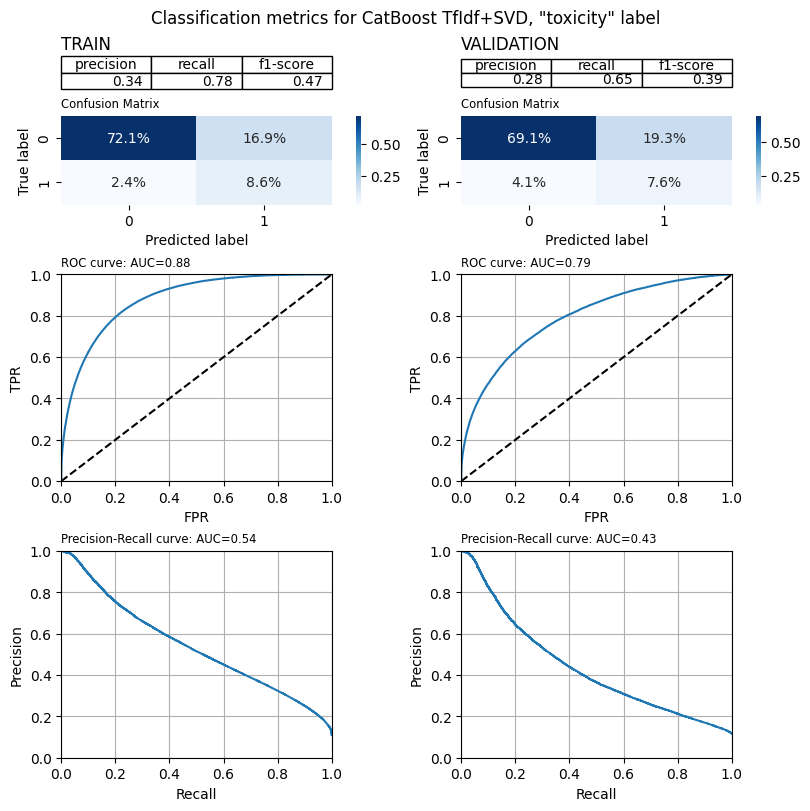

In [27]:
plot_metrics_single(clf_cb, 'CatBoost TfIdf+SVD', 'toxicity',  X_train_tfidf_reduced, y_train['toxicity'], X_val_tfidf_reduced, y_val['toxicity'], 'TRAIN', 'VALIDATION')

## GloVe

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip

--2024-12-06 21:56:36--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip
Resolving huggingface.co (huggingface.co)... 3.171.171.6, 3.171.171.128, 3.171.171.65, ...
Connecting to huggingface.co (huggingface.co)|3.171.171.6|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/stanfordnlp/glove/3123e7f5c3f6a30095d413b12fc3284bbf717acd2a9bed63d1c7c13bf5223352?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27glove.twitter.27B.zip%3B+filename%3D%22glove.twitter.27B.zip%22%3B&response-content-type=application%2Fzip&Expires=1733781396&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMzc4MTM5Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9zdGFuZm9yZG5scC9nbG92ZS8zMTIzZTdmNWMzZjZhMzAwOTVkNDEzYjEyZmMzMjg0YmJmNzE3YWNkMmE5YmVkNjNkMWM3YzEzYmY1MjIzMzUyP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=gkrDfqW-gcjcVWsZUNQLGS7ph02g

In [ ]:
!unzip "/content/glove.twitter.27B.zip"

Archive:  /content/glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


### GloVe 200 (LogReg)

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
EMBEDDINGS_DIM = 200

embeddings_index = dict()
with open(f'/content/glove.twitter.27B.{EMBEDDINGS_DIM}d.txt') as f:
    for line in tqdm(f):
        word, *vector = line.split()
        embeddings_index[word] = np.asarray(vector, dtype='float32')

0it [00:00, ?it/s]

In [ ]:
print(f'GloVe vocab size: {len(embeddings_index):,.0f}')

GloVe vocab size: 1,193,515


In [ ]:
def tokenized_text_to_vec(text, emb_dict, emb_dim, token_sep='\t'):
    words = text.split(token_sep)
    vecs = [emb_dict[word] for word in words if word in emb_dict]
    return np.mean(vecs, axis=0) if vecs else np.zeros(emb_dim)

In [ ]:
X_train_glove = np.vstack(X_train.progress_apply(tokenized_text_to_vec, emb_dict=embeddings_index, emb_dim=EMBEDDINGS_DIM).values)
X_val_glove = np.vstack(X_val.progress_apply(tokenized_text_to_vec, emb_dict=embeddings_index, emb_dim=EMBEDDINGS_DIM).values)

  0%|          | 0/1092977 [00:00<?, ?it/s]

  0%|          | 0/273245 [00:00<?, ?it/s]

In [ ]:
X_train_glove.shape

(1092977, 200)

In [ ]:
objective_lr_glove = ObjectiveLogReg()

study = optuna.create_study(study_name='LogReg GloVe', direction='maximize')
study.optimize(partial(objective_lr_glove, X_train=X_train_glove, y_train=y_train, X_val=X_val_glove, y_val=y_val),
               n_trials=7,
               callbacks=[objective_lr_glove.callback])

[I 2024-12-06 18:26:17,226] A new study created in memory with name: LogReg GloVe
[I 2024-12-06 18:30:05,035] Trial 0 finished with value: 0.2561826789667115 and parameters: {'C': 0.7637973005733376}. Best is trial 0 with value: 0.2561826789667115.
[I 2024-12-06 18:33:27,730] Trial 1 finished with value: 0.2563711066931743 and parameters: {'C': 0.031377166140259025}. Best is trial 1 with value: 0.2563711066931743.
[I 2024-12-06 18:37:06,162] Trial 2 finished with value: 0.2561208763855715 and parameters: {'C': 1.0765086462425362}. Best is trial 1 with value: 0.2563711066931743.
[I 2024-12-06 18:40:43,229] Trial 3 finished with value: 0.25608619685497963 and parameters: {'C': 18.15692661541841}. Best is trial 1 with value: 0.2563711066931743.
[I 2024-12-06 18:43:07,787] Trial 4 finished with value: 0.25561864770721 and parameters: {'C': 0.0022235018510994185}. Best is trial 1 with value: 0.2563711066931743.
[I 2024-12-06 18:46:39,302] Trial 5 finished with value: 0.25611493266822355 and

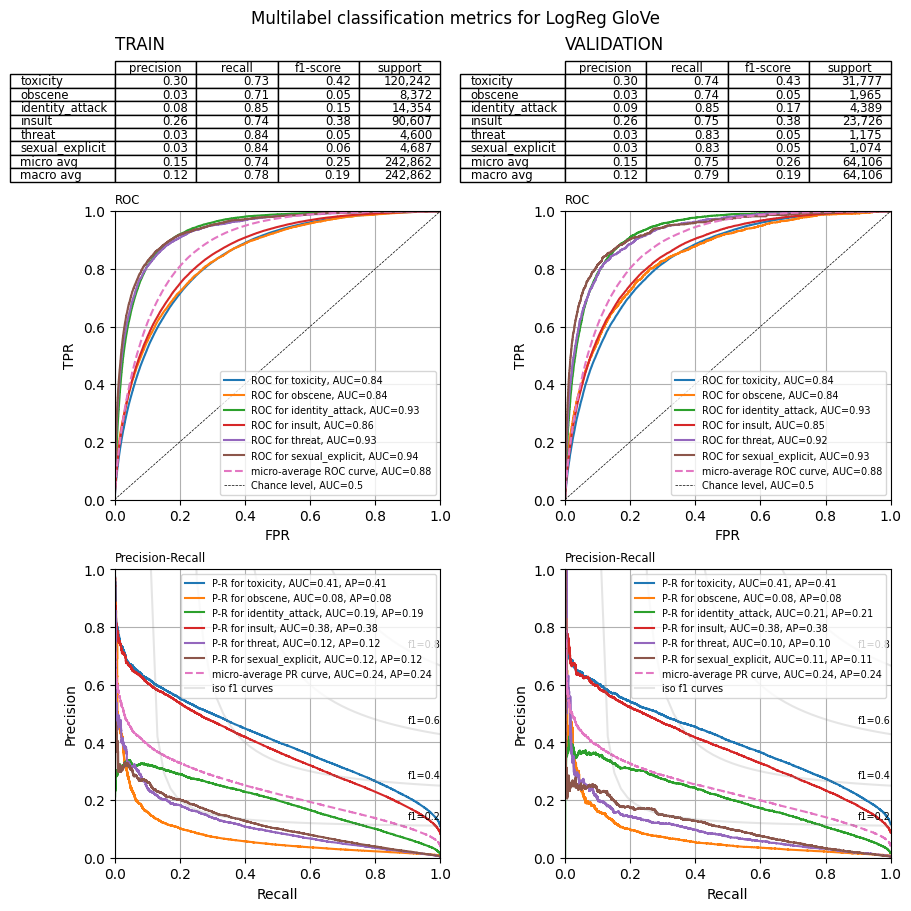

In [ ]:
plot_metrics_multi(objective_lr_glove.best_model, 'LogReg GloVe', toxicity_cols, X_train_glove, y_train, X_val_glove, y_val, 'TRAIN', 'VALIDATION')

### GloVe 200 TfIdf (LogReg)

In [ ]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
vec.fit_transform(X_train)

CPU times: user 29.8 s, sys: 2.25 s, total: 32 s
Wall time: 39.6 s


<1092977x265972 sparse matrix of type '<class 'numpy.float64'>'
	with 26359408 stored elements in Compressed Sparse Row format>

In [ ]:
def get_corpus_embs_tfidf(corpus, emb_dict, emb_dim, tfidf_vectorizer):
    tfidf = tfidf_vectorizer.transform(corpus)
    features = tfidf_vectorizer.get_feature_names_out()
    features_embs = np.array([emb_dict.get(word, np.zeros(emb_dim)) for word in features])

    weighted_embs = tfidf @ features_embs

    norms = np.linalg.norm(weighted_embs, axis=1, keepdims=True)
    weighted_embs = np.divide(weighted_embs, norms, where=norms>0)

    return weighted_embs

In [ ]:
%%time
X_train_glove_tfidf = get_corpus_embs_tfidf(X_train, embeddings_index, EMBEDDINGS_DIM, vec)

CPU times: user 46.8 s, sys: 11 s, total: 57.8 s
Wall time: 1min 35s


In [ ]:
X_train_glove_tfidf.shape

(1092977, 200)

In [ ]:
%%time
X_val_glove_tfidf = get_corpus_embs_tfidf(X_val, embeddings_index, EMBEDDINGS_DIM, vec)

CPU times: user 12.7 s, sys: 1.16 s, total: 13.8 s
Wall time: 16.3 s


In [ ]:
objective_lr_glove_tfidf = ObjectiveLogReg()

study = optuna.create_study(study_name='LogReg GloVe TfIdf', direction='maximize')
study.optimize(partial(objective_lr_glove_tfidf, X_train=X_train_glove_tfidf, y_train=y_train, X_val=X_val_glove_tfidf, y_val=y_val),
               n_trials=5,
               callbacks=[objective_lr_glove_tfidf.callback])

[I 2024-12-06 22:23:48,158] A new study created in memory with name: LogReg GloVe TfIdf
[I 2024-12-06 22:25:33,993] Trial 0 finished with value: 0.2759377629862437 and parameters: {'C': 4.206625907619389}. Best is trial 0 with value: 0.2759377629862437.
[I 2024-12-06 22:27:16,440] Trial 1 finished with value: 0.2759385144998584 and parameters: {'C': 18.433233806369852}. Best is trial 1 with value: 0.2759385144998584.
[I 2024-12-06 22:28:20,180] Trial 2 finished with value: 0.2541620731166445 and parameters: {'C': 0.002297772447764732}. Best is trial 1 with value: 0.2759385144998584.
[I 2024-12-06 22:29:45,743] Trial 3 finished with value: 0.2759631308289026 and parameters: {'C': 2.0445393700694168}. Best is trial 3 with value: 0.2759631308289026.
[I 2024-12-06 22:30:54,281] Trial 4 finished with value: 0.26623227714473235 and parameters: {'C': 0.006605398875945044}. Best is trial 3 with value: 0.2759631308289026.


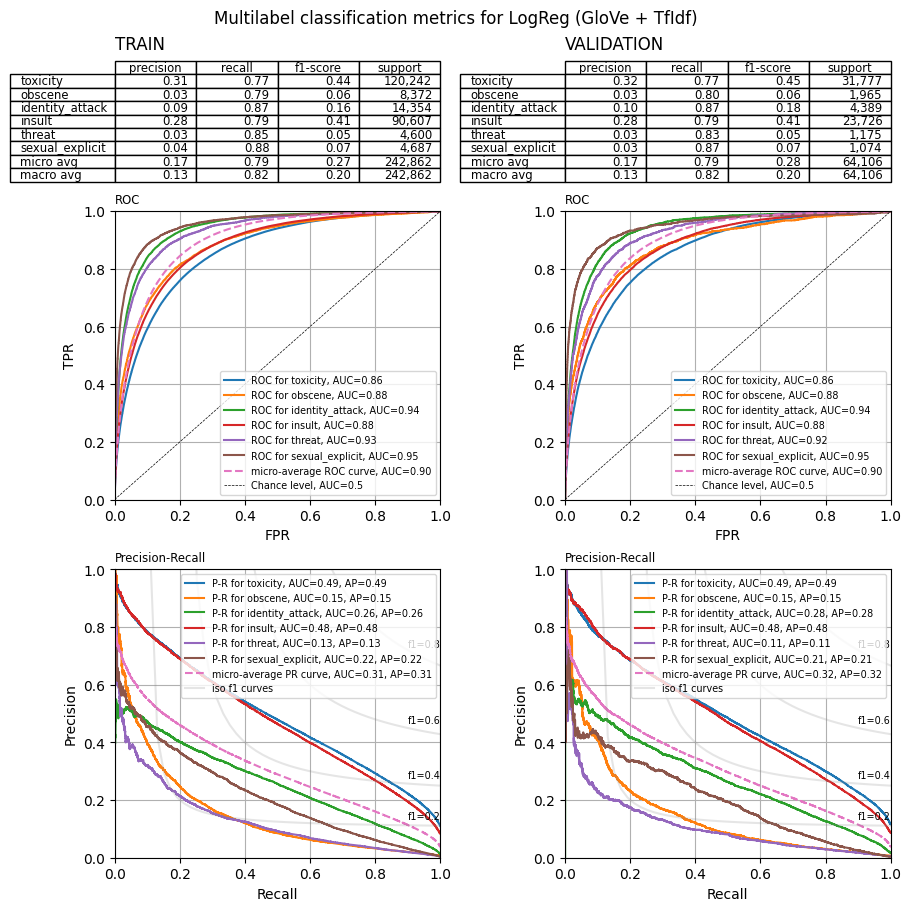

In [ ]:
plot_metrics_multi(objective_lr_glove_tfidf.best_model, 'LogReg (GloVe + TfIdf)', toxicity_cols, X_train_glove_tfidf, y_train, X_val_glove_tfidf, y_val, 'TRAIN', 'VALIDATION')